In [1]:
import numpy as np
import gymnasium as gym
import matplotlib 
#matplotlib.use('Qt5Agg') # Activte it if you want external plot for any interaction
import matplotlib.pyplot as plt
import time
from moviepy import ImageSequenceClip # to generate gif
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ----------------------------------------
# Create the Taxi environment in RGB mode
# ----------------------------------------
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [3]:
# ----------------------------------------
# Get the raw environment to access .P transition dynamics
# ----------------------------------------
raw_env = env.unwrapped  # Needed for .P attribute

In [4]:
# ----------------------------------------
# State and Action Space Details
# ----------------------------------------
# Taxi-v3 environment details:
# - State space size: 500 discrete states
#   (Taxi position: 25 locations (5x5 grid) × passenger location: 5 × destination: 4)
# - Action space size: 6 discrete actions
#   (0: South, 1: North, 2: East, 3: West, 4: Pickup, 5: Dropoff)

n_states = env.observation_space.n  # 500 states
n_actions = env.action_space.n      # 6 actions

n_states , n_actions

(np.int64(500), np.int64(6))

---
---

## Space Info

Passenger locations 5 (R, G, Y, B, or "in taxi")

Destination locations 4 (R, G, Y, B)

observation space 5 rows × 5 columns × 5 passenger locations × 4 destinations = 500 states

The environment uses a single integer (0–499) to represent each state internally.


## Space Decoding

You can decode a state index using:

```python
env = gym.make("Taxi-v3")
state = 123  # some state index
decoded = env.unwrapped.decode(state)
print(decoded)  # returns (taxi_row, taxi_col, passenger_location, destination)
```

## Space Encoding

How to encode it back:

```python
encoded = env.unwrapped.encode(taxi_row, taxi_col, passenger_loc, destination)
```
---
---

gym.make() wraps environments in extra logic (like time limits). These wrappers don’t expose internal attributes like .P.

To access internal MDP properties (which only exist in classic Gym environments like Taxi)
use:

```python
env.unwrapped.P[s][a] # "s" for state and "a" for action
```
This returns :
 * **probability**: the transition probability
 * **next state**: an integer that represents the next state
 * **reward**: reward of transition from current state to the next state
 * **done**: a boolean for terminating the episode
 
<br><br>

Note that P[s][a] is the list of transitions and each transition is (probability, next_state, reward, terminated) e.g. Prob: 0.333, Next: 0, Reward: 0.0, Done: False

In [5]:
# ----------------------------------------
# Initialize random policy and zero value function
# ----------------------------------------
policy = np.random.choice(n_actions, size=n_states)
V = np.zeros(n_states) # value function 

In [6]:
# ----------------------------------------
# Policy Evaluation Function
# ----------------------------------------
def policy_evaluation(policy, V, env, discount_factor=0.99, theta=1e-5):
    while True:
        delta = 0
        V_new = np.copy(V)
        for s in range(n_states):
            a = policy[s]
            v = 0
            for prob, next_state, reward, done in env.P[s][a]:
                v += prob * (reward + discount_factor * V[next_state])
            V_new[s] = v
            delta = max(delta, abs(V_new[s] - V[s]))
        V = V_new
        if delta < theta:
            break
    return V


In [7]:
# ----------------------------------------
# Policy Improvement Function
# ----------------------------------------
def policy_improvement(V, env, discount_factor=0.99):
    """
    Improve the policy given the current value function V.
    Return the improved policy and whether it is stable.
    """
    policy_stable = True
    new_policy = np.copy(policy)
    
    for s in range(n_states):
        action_values = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                action_values[a] += prob * (reward + discount_factor * V[next_state])
        best_action = np.argmax(action_values)
        if policy[s] != best_action:
            policy_stable = False
        new_policy[s] = best_action
    return new_policy, policy_stable

In [8]:
# ----------------------------------------
# Policy Iteration Algorithm with progress output
# ----------------------------------------
def policy_iteration(env, policy, V, max_iterations=1000,print_out_step=50):
    for iteration in range(1, max_iterations + 1):
        if((iteration+1)%print_out_step==0):
            print(f"\nPolicy Iteration: {iteration}")
        V = policy_evaluation(policy, V, env)
        policy, stable = policy_improvement(V, env)
        if((iteration+1)%print_out_step==0):
            print(f"Policy Improvement done. Policy stable: {stable}")
        if stable:
            print("Policy iteration converged!")
            return policy, V
    print("Policy iteration reached max iterations without convergence.")
    return policy, V


<br><br>

### Training

In [9]:
trained_policy, trained_V = policy_iteration(raw_env, policy, V)



Policy Iteration: 49
Policy Improvement done. Policy stable: False

Policy Iteration: 99
Policy Improvement done. Policy stable: False

Policy Iteration: 149
Policy Improvement done. Policy stable: False

Policy Iteration: 199
Policy Improvement done. Policy stable: False

Policy Iteration: 249
Policy Improvement done. Policy stable: False

Policy Iteration: 299
Policy Improvement done. Policy stable: False

Policy Iteration: 349
Policy Improvement done. Policy stable: False

Policy Iteration: 399
Policy Improvement done. Policy stable: False

Policy Iteration: 449
Policy Improvement done. Policy stable: False

Policy Iteration: 499
Policy Improvement done. Policy stable: False

Policy Iteration: 549
Policy Improvement done. Policy stable: False

Policy Iteration: 599
Policy Improvement done. Policy stable: False

Policy Iteration: 649
Policy Improvement done. Policy stable: False

Policy Iteration: 699
Policy Improvement done. Policy stable: False

Policy Iteration: 749
Policy Improv

---
<br><br>

### Visualizing the optimal policy

In [10]:
# -------------------------
# Action Symbols for Display
# -------------------------
action_arrows = {
    0: '↑',  # South
    1: '↓',  # North
    2: '→',  # East
    3: '←',  # West
    4: 'P',  # Pickup
    5: 'D',  # Dropoff
}

In [11]:
# -------------------------
# Print the Optimal Policy
# -------------------------
def print_policy(policy):
    print("\nOptimal Policy:")
    for s in range(n_states):
        print(f"State {s}: {action_arrows[trained_policy[s]]}")

print_policy(policy)


Optimal Policy:
State 0: P
State 1: P
State 2: P
State 3: P
State 4: ↑
State 5: ↑
State 6: ↑
State 7: ↑
State 8: ↑
State 9: ↑
State 10: ↑
State 11: ↑
State 12: ↑
State 13: ↑
State 14: ↑
State 15: ↑
State 16: D
State 17: ↑
State 18: ↑
State 19: ↑
State 20: ←
State 21: ←
State 22: ←
State 23: ←
State 24: ↑
State 25: ↑
State 26: ↑
State 27: ↑
State 28: ↑
State 29: ↑
State 30: ↑
State 31: ↑
State 32: ↑
State 33: ↑
State 34: ↑
State 35: ↑
State 36: ←
State 37: ↑
State 38: ↑
State 39: ↑
State 40: ↑
State 41: ↑
State 42: ↑
State 43: ↑
State 44: →
State 45: →
State 46: →
State 47: →
State 48: ↑
State 49: ↑
State 50: ↑
State 51: ↑
State 52: ↑
State 53: ↑
State 54: ↑
State 55: ↑
State 56: ↑
State 57: →
State 58: ↑
State 59: ↑
State 60: ↑
State 61: ↑
State 62: ↑
State 63: ↑
State 64: →
State 65: →
State 66: →
State 67: →
State 68: ↑
State 69: ↑
State 70: ↑
State 71: ↑
State 72: ↑
State 73: ↑
State 74: ↑
State 75: ↑
State 76: ↑
State 77: →
State 78: ↑
State 79: ↑
State 80: ↑
State 81: ↑
State 82:

In [12]:
# -------------------------
# Render Policy Using RGB Frames
# -------------------------



def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)
    
    
def run_multi_episodes(env, policy, num_episodes=3):
    total_frames = []
    total_reward = []
    total_steps = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        while not done and steps < 50: # A good solution is obtained less than 50 actions
            # Capture the rendered frame
            frame = env.render()
            total_frames.append(frame)

            # Take action from learned policy
            action = policy[state]
            state, reward, done, truncated, info = env_vis.step(action)
            episode_reward += reward
            steps += 1
        total_reward.append(episode_reward)
        total_steps.append(steps)
    return total_frames, total_steps, total_reward



In [13]:

env_vis = gym.make("Taxi-v3", render_mode="rgb_array")

total_frames, total_steps, total_reward = run_multi_episodes(env_vis, trained_policy, num_episodes=4)
print('pls wait, we are generating gif...')
# Decrease fps to see movement clearly.
create_gif(total_frames, f"Taxi-policy-iteration.gif", fps=2) 

print(f"\n\nThere are {len(total_steps)} episodes:\n")
for i,t in enumerate(zip(total_steps,total_reward)):
    print(f'    -- Epsiode {i}      length {t[0]}      return {t[1]}')

pls wait, we are generating gif...
MoviePy - Building file Taxi-policy-iteration.gif with imageio.




There are 4 episodes:

    -- Epsiode 0      length 16      return 5
    -- Epsiode 1      length 14      return 7
    -- Epsiode 2      length 18      return 3
    -- Epsiode 3      length 17      return 4


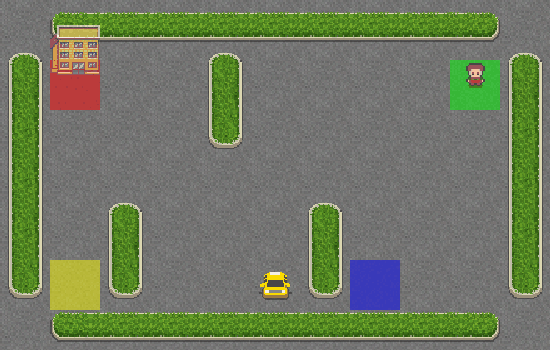

In [14]:
Image(filename='./Taxi-policy-iteration.gif')